In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import GPy
from getdist import plots, MCSamples

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../../')
import pk_tools as pk
import fg_tools as fg

In [3]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

In [4]:
# data:
data = pd.read_pickle('../../Data/data.pkl')
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise
HI_noise_data = data.beam.HI_noise
FGwpol_HI_noise_lognorm = data.beam.FGwpol_HI_noise_lognorm
lognorm = data.beam.lognorm
freqs = data.freqs
# multinest results:
multinest_results = pd.read_pickle('../../Data/multinest_results.pkl')
multinest = multinest_results.wpol
multinest_lognorm = multinest_results.wpol_lognorm

Lognormal case:

In [5]:
samples_lognorm = multinest_lognorm.samples
samples_lognorm[:,0] = samples_lognorm[:,0]/1e4
samples_lognorm[:,4] = samples_lognorm[:,4]/1e-3
weights_lognorm = multinest_lognorm.weights

mask_lognorm = weights_lognorm > 1e-4

names = ['fgvar', 'fglen', 'polvar', 'pollen', 'expvar', 'explen']
labels =  ['$\sigma_\mathrm{smooth} / 10^4$', '$\ell_\mathrm{smooth}$', '$\sigma_\mathrm{pol}$', '$\ell_\mathrm{pol}$', 
              '$\sigma_{21} / 10^{-3}$', '$\ell_{21}$']
samples_plot = MCSamples(samples=samples_lognorm[mask_lognorm,:], weights=weights_lognorm[mask_lognorm], 
                     names = names, labels = labels)

Removed no burn in


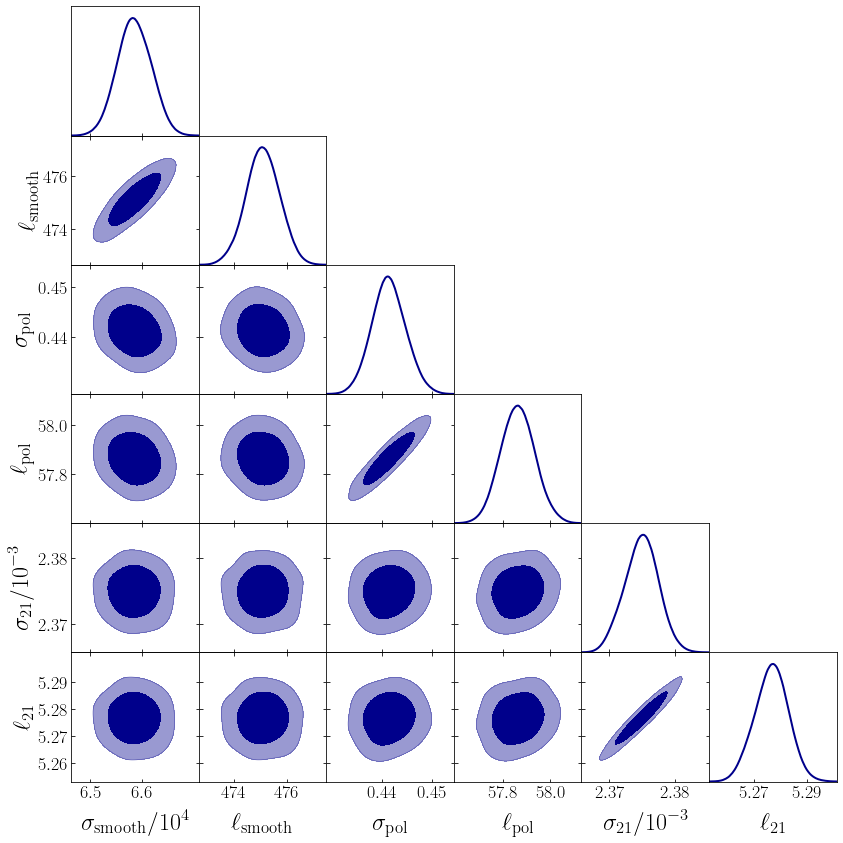

In [6]:
# Triangle plot
g = plots.get_subplot_plotter()
samples_plot.updateSettings({'contours': [0.68, 0.95]})
g.settings.axes_labelsize=27
g.settings.axes_fontsize=21
g.settings.legend_fontsize=22
g.settings.axis_marker_lw=2
g.settings.axis_marker_ls='dotted'
g.triangle_plot([samples_plot], filled=True,
                legend_loc='upper right',
                line_args=[{'lw':2, 'color':'darkblue'}],
                contour_colors=['darkblue'],fontsize=22)

In [16]:
#g.export('../figs/posterior_wpol_lognorm.pdf')

In [7]:
kern_smooth = GPy.kern.RBF(1, variance = multinest_lognorm.rbf1_var, lengthscale = multinest_lognorm.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest_lognorm.rbf2_var, lengthscale = multinest_lognorm.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest_lognorm.exp_var, lengthscale = multinest_lognorm.exp_len)

Input = FGwpol_HI_noise_lognorm

gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [8]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,65844.42591992715,+ve,
sum.rbf.lengthscale,475.1083823587774,+ve,
sum.rbf_1.variance,0.4413095597015492,+ve,
sum.rbf_1.lengthscale,57.863746347981035,+ve,
sum.Exponential.variance,0.002374978989580968,+ve,
sum.Exponential.lengthscale,5.276922518617425,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


In [9]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/lz
kmax, kmax_par = 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_par = 2*kmin, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)

In [10]:
n_samples = 10
pk3d_corr, pk1d_corr, samples = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, 
                                                kbins_par, kbins, w, W)

In [11]:
# true HI power spectrum:
HI_pk_ln = pk.getpk(HI_noise_data + lognorm, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# residual power spectrum from GPR, with bias correction:
GPR_pk_ln = pk.getpk(gpr_result.res, w, W, nx, ny, nz, lx, ly, lz, kbins)[0] + pk3d_corr

No lognormal case:

In [12]:
kern_smooth = GPy.kern.RBF(1, variance = multinest.rbf1_var, lengthscale = multinest.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.rbf2_var, lengthscale = multinest.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.exp_var, lengthscale = multinest.exp_len)

Input = FGwpol_HI_noise_data

gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

In [13]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,67161.78736295136,+ve,
sum.rbf.lengthscale,475.3038673456153,+ve,
sum.rbf_1.variance,0.4992046749695261,+ve,
sum.rbf_1.lengthscale,58.41604678366568,+ve,
sum.Exponential.variance,0.0012143664675416637,+ve,
sum.Exponential.lengthscale,6.725670650710272,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


In [14]:
pk3d_corr, pk1d_corr, samples = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, 
                                                kbins_par, kbins, w, W)

In [15]:
# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# residual power spectrum from GPR, with bias correction:
GPR_pk = pk.getpk(gpr_result.res, w, W, nx, ny, nz, lx, ly, lz, kbins)[0] + pk3d_corr

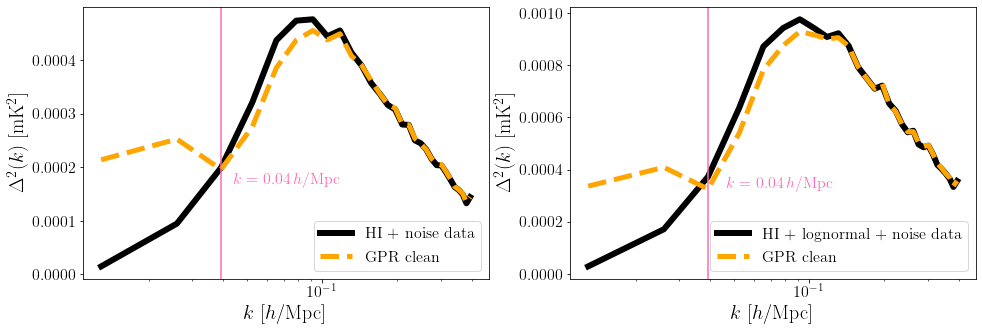

In [16]:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + noise data')
plt.plot(k, (k*k*k*GPR_pk)/(2*np.pi*np.pi), ls='dashed', c='orange', lw=5, label='GPR clean')
plt.legend(loc='lower right')
plt.axvline(k[2], c='hotpink')
plt.text(k[0]*3.4, 0.00017, r'$k = 0.04 \, h$/Mpc', c='hotpink')
plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)
plt.xscale('log')

plt.subplot(122)
plt.plot(k, (k*k*k*HI_pk_ln)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + lognormal + noise data')
plt.plot(k, (k*k*k*GPR_pk_ln)/(2*np.pi*np.pi), ls='dashed', c='orange', lw=5, label='GPR clean')
plt.legend()
plt.axvline(k[2], c='hotpink')
plt.text(k[0]*3.6, 0.00033, r'$k = 0.04 \, h$/Mpc', c='hotpink')
plt.xlabel('$k$ [$h$/Mpc]', fontsize=20)
plt.ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)
plt.xscale('log')

#plt.savefig('../figs/pk_wpol_lognorm', dpi=200, bbox_inches="tight")